# Task 2

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
# New imports for HW2:
import requests
from bs4 import BeautifulSoup

See task1.ipynb for explanations regarding the next four cells.

In [2]:
form_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter'
base_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html'
params = {'ww_i_reportModel':'133685247', 
          'ww_i_reportModelXsl':'133685270', 
          'ww_x_GPS':'-1'}

In [3]:
page = requests.get(form_url, params)

In [4]:
soup = BeautifulSoup(page.content, 'lxml')
keys = {}
for s in soup.find_all('select'):
    for o in s.find_all('option'):
        if o.text != '': # No need for empty (default values)
            keys.setdefault(s['name'], {}).update({o.text: o['value']})
            
# A helper method to change a parameter
# name : the parameter
# key : the key in plain text (eg. 'Bachelor semestre 1')
def updateParam(name, key):
    return params.update({name: keys[name][key]})

In [5]:
updateParam('ww_x_UNITE_ACAD', 'Informatique')


Let's compute a list of semesters types and years that interest us.

In [6]:
semestres = [s for s in keys['ww_x_PERIODE_PEDAGO'] if (s.find('Master') != -1)]
years = keys['ww_x_PERIODE_ACAD']

## Retrieveing the data

For each possible combination of years and semester types, we retrieve the relevant table. Then, we parse the HTML table using [pandas.read_html](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html).

Then, we add the semester and the year in a column and save the dataframe in the `dataframes` which we then concatenate to the data that we will work with.

In [7]:
students = {}
dataframes = []
for year in years.keys():
    for sem in semestres:
        updateParam('ww_x_PERIODE_ACAD', year)
        updateParam('ww_x_PERIODE_PEDAGO', sem)
        r = requests.get(base_url, params)
        try:
            data = pd.read_html(r.content, header=1)#, index_col=10)
            if not data:
                continue
            data = data[0]
            data["sem"] = sem
            data["year"] = year
            dataframes.append(data)
        except ValueError:
            continue

data = pd.concat(dataframes)
raw_data = data.copy()   # Copy for further tests

## Cleaning 
We replace NaNs with empty strings on string columns, and clean the gender column.

In [8]:
def gender(row):
    if row["Civilité"] == "Monsieur":
        return "M" 
    elif row["Civilité"] == "Madame":
        return "F"
    else:
        return "U"

data["gender"] = data.apply(gender, axis=1)
data["mineur"] = data["Mineur"].fillna("")#.apply(mineur_exists, axis=1)
data["spe"] = data["Spécialisation"].fillna("")#apply(spe, axis=1)

## Aggregation and filtering

We then aggregate and unstack the data and filter on the following criterions:

  * Remove all entries where the student has
      * No specialization/minor AND no semester 1 & 2
      * A specialization/minor AND no semester 1 & 3

In [9]:
data = data[["No Sciper", "spe", "mineur", "sem", "gender"]]
data["sem_count"] = 0.5 # used for aggregation

aggregate = data.groupby(["No Sciper", "sem", "gender"]).agg({"sem_count":"sum", "mineur":"last", "spe": "last"})
aggregate = aggregate.reset_index().set_index(["No Sciper", "sem", "gender", "mineur", "spe"])
unstacked = aggregate.unstack(level=1)

# Split the DF in two different DFs to perform aggregation and then concatenate
# because aggregating on a multilevel column is not easy.

semesters = unstacked.reset_index()[["No Sciper", "gender", "sem_count"]].groupby(["No Sciper", "gender"]).sum()
mineur_spe = unstacked.reset_index()[["No Sciper", "gender", "spe", "mineur"]].replace(np.nan, "").groupby(["No Sciper", "gender"]).last()
concatenated = pd.concat([mineur_spe, semesters], axis=1)

filtered = concatenated[(concatenated["sem_count"]["Master semestre 1"] > 0) | (concatenated["sem_count"]["Master semestre 2"] > 0)]
filtered = filtered[(filtered["sem_count"]["Master semestre 2"] > 0) | (filtered["sem_count"]["Master semestre 3"] > 0)]
filtered = filtered[((filtered["spe"] == "") & (filtered["mineur"] == ""))|\
                     ((filtered["sem_count"]["Master semestre 1"] > 0) & (filtered["sem_count"]["Master semestre 3"] > 0))]

/Users/flo/anaconda3/lib/python3.5/site-packages/pandas/core/base.py:320: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)


## Correcting missing data
Lots of entries have missing data regarding the master project. We assume that all students with enough master semesters likely did a master project, so we add an entry where data is missing.

In [10]:


def fix_master_project(row):
    if pd.isnull(row["sem_count"]["Projet Master automne"]) and pd.isnull(row["sem_count"]["Projet Master printemps"]):
        return 0.5
    return row["sem_count"]["Projet Master automne"]

filtered[("sem_count", "Projet Master automne")] = filtered.apply(fix_master_project, axis=1)

## General average time to finish master's degree

In [11]:
general_mean = filtered.stack().groupby(level=[0,1]).sum()["sem_count"].mean()
print("Average Time to finish the master's degree : {} semesters".format(str(general_mean)))

Average Time to finish the master's degree : 2.1174540682414698 semesters


## Average time to finish master's degree per specialization

In [12]:
stacked = filtered.stack()
stacked = stacked.reset_index().drop(["sem", "mineur"], axis=1)#.groupby(["No Sciper","spe"]).sum()
stacked["sem_count"] = stacked["sem_count"].fillna(0)
stacked["spe"] = stacked["spe"].fillna("")
semesters_per_student = stacked.groupby("No Sciper").agg({"sem_count": "sum", "spe": "first"})
grouped_by_spe = semesters_per_student.groupby("spe")
semesters_avg_per_spe = grouped_by_spe.mean()
semesters_avg_per_spe

,sem_count
spe,
,2.004655
Biocomputing,2.500000
Computer Engineering - SP,2.315789
Computer Science Theory,2.000000
Data Analytics,2.000000
Foundations of Software,2.437500
Information Security - SP,2.142857
Internet Information Systems,2.000000
Internet computing,2.380952


## Statistical significance 

We use the Mann-Whitney U test again to compare each specialization average time against the general average, and list all specializations for which the p-value is less than 0.05. See task1.ipynb for more explanations about the Mann-Whitney U test.

In [13]:
from scipy import stats

significant_spe = []
for spe in semesters_avg_per_spe.index.unique():
    if spe == "":
        continue
    T, p_value = stats.mannwhitneyu(
        semesters_per_student["sem_count"], 
        grouped_by_spe.get_group(spe)["sem_count"]
    )
    if p_value < 0.05:
        significant_spe.append(spe)
pd.DataFrame(significant_spe).rename(columns={0: "Specialization"})

,Specialization
0,Computer Engineering - SP
1,Foundations of Software
2,Internet computing
3,"Signals, Images and Interfaces"


# Task 3
We use the same process and tests as in the first task.

In [14]:
grouped_by_gender = filtered.stack().groupby(level=[0,1]).sum().rename(columns={"sem_count": "average time"}).groupby(level=1)
grouped_by_gender.mean()

,average time
gender,
F,2.142157
M,2.113636


In [15]:
males = grouped_by_gender.get_group('M')["average time"]
females = grouped_by_gender.get_group('F')["average time"]
from scipy import stats

T, p_value = stats.mannwhitneyu(females, males)
print('p-value:', p_value)

p-value: 0.318081616017


As we can see, we don't have a low enough p-value to assert that the difference between males and females is statistically significant.

## Scatter plot

First, we need the minimum year per sciper. Even if it might be cleaner, we'll start back from raw_data and then concat with the data.

In [16]:
just_years = raw_data[['No Sciper', 'year']].copy()
just_years['year'] = just_years['year'].apply(lambda x: int(x.split('-')[0]))
min_year = just_years.groupby('No Sciper').min()

def group_with_year(group_ref):
    return pd.concat([grouped_by_gender.get_group(group_ref).reset_index().set_index('No Sciper'), min_year], axis=1).dropna()
    
male_with_years = group_with_year('M')
female_with_years = group_with_year('F')

female_with_years.head()

,gender,average time,year
No Sciper,,,
154573,F,3.0,2007
159998,F,2.0,2008
160148,F,2.0,2007
161024,F,1.5,2007
161091,F,2.5,2008


Then, just scatter plot it

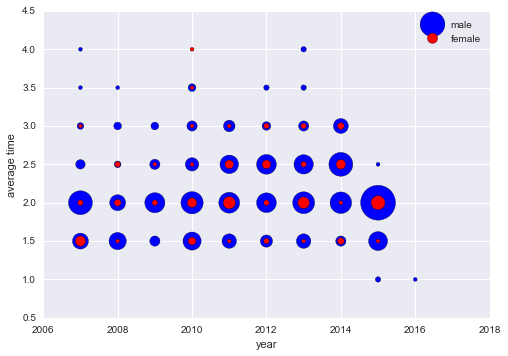

In [17]:
#plt.scatter(male_with_years['year'], male_with_years['average time'], color='b')
#plt.scatter(female_with_years['year'], female_with_years['average time'], color='r')

def nice_plot(base_data, label, c, fig):
    counts = []
    for group in base_data.groupby(['year', 'average time']):
        counts.append({
                'year': group[0][0],
                'average time': group[0][1],
                'count': group[1].size
            })
    
    counts = pd.DataFrame(counts)
    return counts.plot(kind='scatter', label=label, color=c, x='year', y='average time', s=counts['count'] * 5, ax=fig)

fig = nice_plot(male_with_years, 'male', 'b', None)
nice_plot(female_with_years, 'female', 'r', fig)

_For the scatter plot, thanks to [these guys](https://github.com/SolalPirelli/ADA2016)._